<a href="https://colab.research.google.com/github/alvinadar/DBSCAN-Project-/blob/main/Finding_suitable_eps_min_samples_for_DBSCAN_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding eps and min_samples based on F1 score and silhouette score

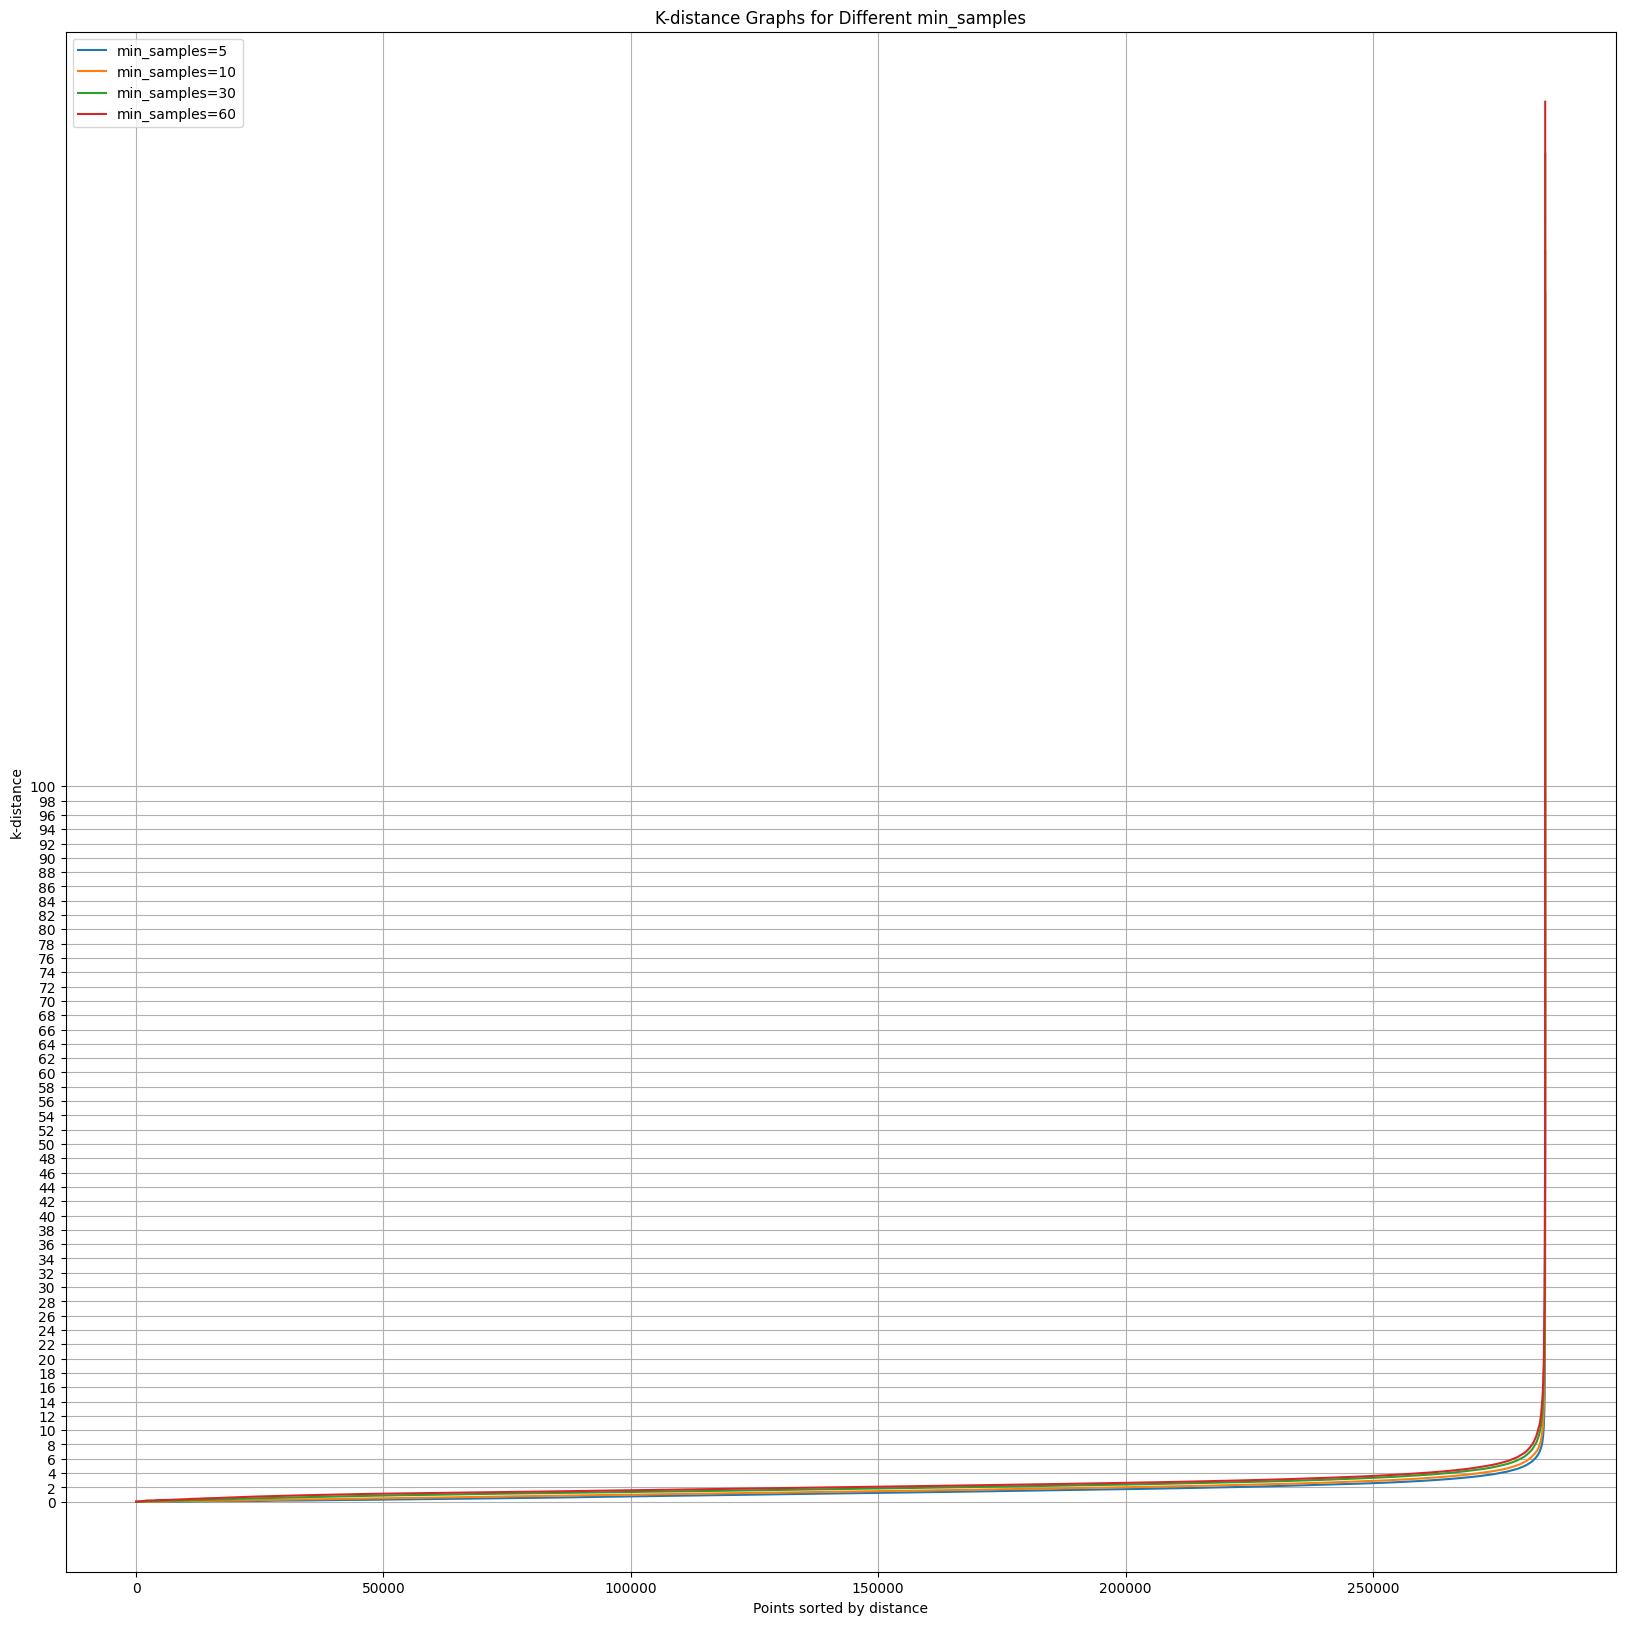

    eps  min_samples  precision    recall        f1  silhouette_score
12  2.0            5   0.008355  0.851626  0.016547         -0.181121
13  2.0           10   0.007461  0.939024  0.014804         -0.145292
14  2.0           30   0.005695  0.953252  0.011321         -0.088692
15  2.0           60   0.004787  0.961382  0.009526         -0.123645
8   1.0            5   0.003325  0.975610  0.006627         -0.268074
9   1.0           10   0.002947  0.987805  0.005877         -0.259658
10  1.0           30   0.002435  0.991870  0.004858         -0.280828
4   0.5            5   0.002408  0.981707  0.004805         -0.348105
5   0.5           10   0.002193  0.993902  0.004376         -0.376325
11  1.0           60   0.002189  0.997967  0.004368         -0.305430
0   0.3            5   0.002129  0.981707  0.004249         -0.423938
1   0.3           10   0.001995  0.997967  0.003982         -0.426718
6   0.5           30   0.001942  1.000000  0.003876         -0.388058
2   0.3           30

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score

# =========================
# 1. Load & prepare dataset
# =========================
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

# Drop 'Time' and separate features/labels
X = df.drop(columns=["Time", "Class"])
y = df["Class"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 2. K-distance graphs
# =========================
min_samples_list = [5, 10, 30, 60]

plt.figure(figsize=(20,20))
for min_samples in min_samples_list:
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)

    distances = np.sort(distances[:, -1])  # k-th NN distance
    plt.plot(distances, label=f"min_samples={min_samples}")

plt.xlabel("Points sorted by distance")
plt.ylabel("k-distance")
plt.title("K-distance Graphs for Different min_samples")
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0,100.1,2))
plt.show()

# =========================
# 3. Grid search DBSCAN
# =========================
eps_values = [0.3, 0.5, 1.0, 2.0]
min_samples_values = [5, 10, 30, 60]

results = []

for eps in eps_values:
    for min_s in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1)
        labels = dbscan.fit_predict(X_scaled)

        # Noise (-1) -> predict fraud (1), clusters -> normal (0)
        y_pred = (labels == -1).astype(int)

        precision = precision_score(y, y_pred, zero_division=0)
        recall = recall_score(y, y_pred, zero_division=0)
        f1 = f1_score(y, y_pred, zero_division=0)
        sil_score = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else -1

        results.append((eps, min_s, precision, recall, f1, sil_score))

# Results table
results_df = pd.DataFrame(results, columns=["eps", "min_samples", "precision", "recall", "f1", "silhouette_score"])
print(results_df.sort_values(by="f1", ascending=False))

# We choose the best f1 score So, the optimum eps and min_sample value is eps 2.0 and min_samples 5.

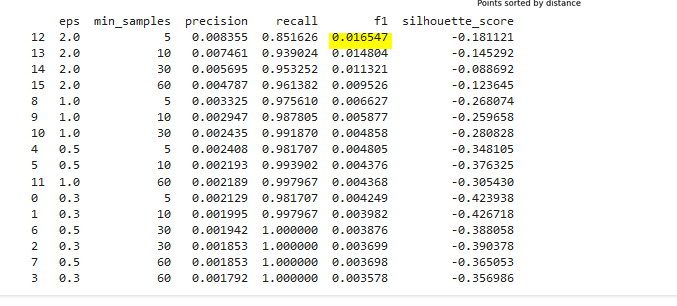

Although based on graph above, it shows as 18 as optimum eps value for min_samples=5, we have to justify against F1 score and Silhouette score. As a standard procedure , we need to start with eps=0.3, 0.5, 1.0 and 2.0. We also have to start with min_samples=5, 10 30 60. Since Silhouette score is showing all negatives value, it shows DBSCAN is not a good clustering algorithm for this dataset. So, we ignore silhouette score. If we increase the eps value to higher like 18 (as suggested in the graph plot above), , the F1 score will keep on decreasing. That's why we need to start with lower eps value. F1 curve looks like a hill where:

1.) Very small eps (<1) --> F1 low (too much noise)

2.) Moderate eps (1-3) --> F1 peaks

3.) Large eps (5-10) --. F1 drops again

# So our goal here is fraud detection (supervised evaluation with F1). So, we choose eps=2.0 and min_samples=5, which has the highest F1 score even though silhouette score is poor. We are aligning DBSCAN's noise points with fraud, so F1 matters most. Based on silhouette score values (which are all negaives value) it shows DBSCAN is grouping fraud + non-fraud into mixed clusters.